In [311]:
import numpy as np
import cv2
from matplotlib.path import Path
from scipy.sparse import dok_matrix, csc_matrix, lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt


## Task1

In [470]:
def mark_vertices(img):
    vertices = []

    %matplotlib widget
    fig, ax = plt.subplots()
    plt.imshow(img, cmap='gray')
    def onclick(event):
        if event.xdata is not None and event.ydata is not None:
            x, y = int(event.xdata), int(event.ydata)
            vertices.append([x, y])
            ax.scatter(x, y, color='red')
            fig.canvas.draw()

    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    plt.show()
    
    return vertices

In [472]:
def region_fill(img, vertices):
    path = Path(vertices, closed=True)
    x, y = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))
    points = np.vstack((x.ravel(), y.ravel())).T
    mask = path.contains_points(points).reshape(img.shape)
    
    # Extract region indices correctly
    region_indices = np.transpose(np.nonzero(mask)) 

    num_pixels = len(region_indices)
    A = dok_matrix((num_pixels, num_pixels), dtype=np.float32)
    b = np.zeros(num_pixels)

    for idx, (i, j) in enumerate(region_indices):
        A[idx, idx] = 4  # Laplacian coefficient
        neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
        for ni, nj in neighbors:
            if 0 <= ni < img.shape[0] and 0 <= nj < img.shape[1]:
                if mask[ni, nj]:
                    n_idx = np.flatnonzero((region_indices == [ni, nj]).all(axis=1))
                    if n_idx.size > 0:
                        A[idx, n_idx[0]] = -1
                else:
                    b[idx] += img[ni, nj]
                    
    A = A.tocsc()
    x = spsolve(A, b)
    filled_img = img.copy()
    filled_img[mask] = x.clip(0, 255)

    return filled_img


In [473]:
def plot_imgs(before, after, vertex):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(before, cmap='gray')
    polygon = plt.Polygon(vertex, edgecolor='r', facecolor='none')
    ax[0].add_patch(polygon)
    
    ax[1].imshow(after, cmap='gray')

In [474]:
gray_img = cv2.imread('img.jpg', cv2.IMREAD_GRAYSCALE)
vertices = mark_vertices(gray_img)
# vertices = [[1411, 51], [994, 149], [1116, 460], [1442, 490], [1601, 286]]

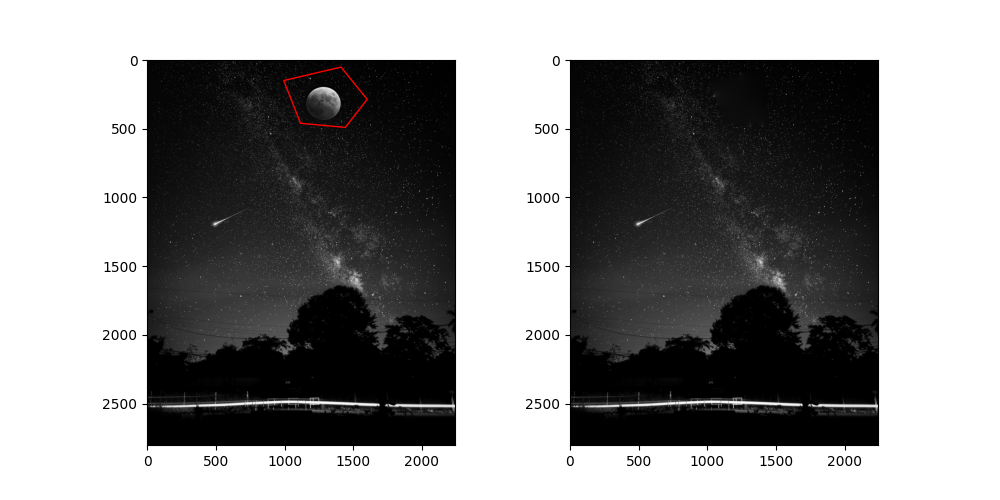

In [340]:
filled_img = region_fill(gray_img, vertices)
plot_imgs(gray_img, filled_img, vertices)

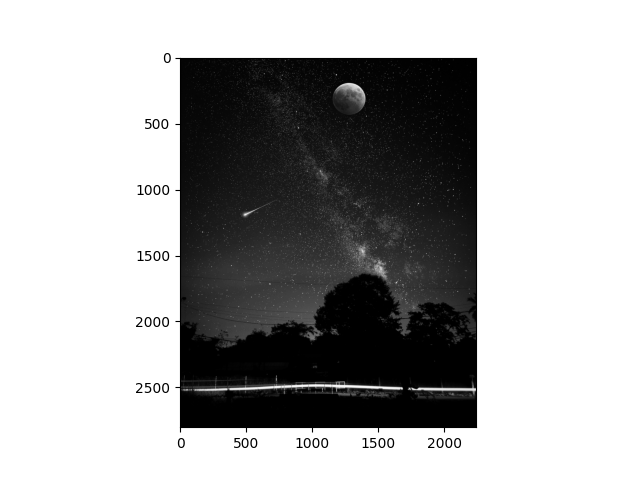

In [341]:
vertices_1 = mark_vertices(gray_img)
# [[1681, 1768], [1529, 1541], [1211, 1609], [1090, 1784], [1340, 1890], [1567, 1852]]

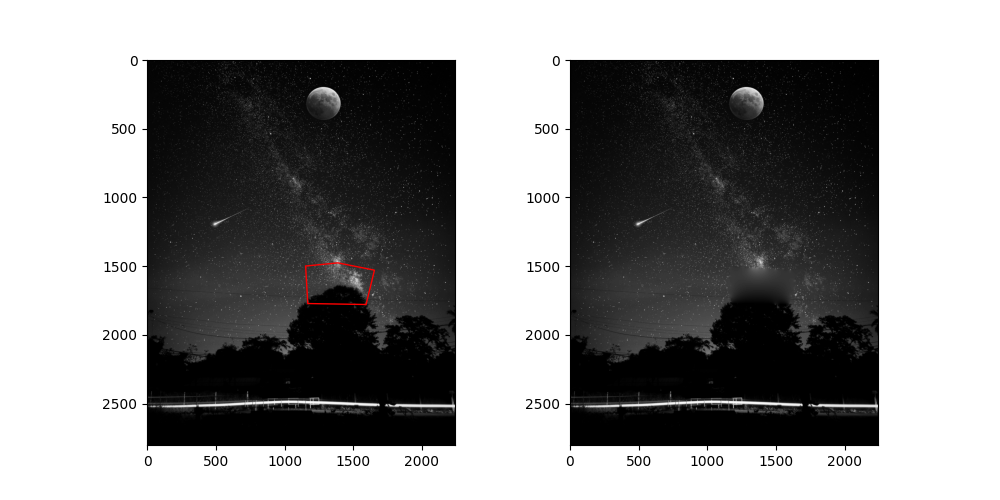

In [344]:
filled_img = region_fill(gray_img, vertices_1)
plot_imgs(gray_img, filled_img, vertices_1)

As the size of the selected region increases, the computation likely to become larger. This is because the algorithm needs to solve for the larger number of unknowns (intensity values) inside the mask.

For smooth regions, the filling appears natural and seamless, blending well with the surrounding pixels. However, in regions with high frequency or detailed textures, the filled areas appear unnatural or limited in maintaining textures.

## Task2

In [606]:
def apply_gradient(src, dst, offset, vertices, mode):
    # Adjust vertices based on the offset and create a mask for the region
    adjusted_vertices = np.array(vertices) + offset

    path = Path(adjusted_vertices, closed=True)
    x, y = np.meshgrid(np.arange(src.shape[1]), np.arange(src.shape[0]))
    points = np.vstack((x.ravel(), y.ravel())).T
    mask = path.contains_points(points).reshape(src.shape)
    region_indices = np.transpose(np.nonzero(mask)) 
    
    region = np.argwhere(mask) # y, x coordinates 
    region_dic = {(y,x): i for i, (y,x) in enumerate(region)}
    n = len(region)
    
    # Create sparse matrix A and vector b for the Poisson equation
    A = dok_matrix((n, n), dtype=np.float32) 
    b = np.zeros(n)

    # Fill the matrix A and vector b
    for idx, (i, j) in enumerate(region_indices):
        A[idx, idx] = 4  # Laplacian coefficient
        neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
        
        for ni, nj in neighbors:
            k = region_dic.get((ni, nj))
            if k is not None:
                A[idx, k] = -1
            else:
                b[idx] += dst[ni, nj]
        
            if mode == 'import':
                v = src[i - offset[1], j - offset[0]] - src[ni - offset[1], nj - offset[0]]
                b[idx] += v

            elif mode == 'mixed':
                v_src = src[i - offset[1], j - offset[0]] - src[ni - offset[1], nj - offset[0]]
                v_dst = dst[i, j] - dst[ni, nj]
                if abs(v_src) > abs(v_dst):
                    b[idx] += v_src
                else:
                    b[idx] += v_dst

    # Solve the Poisson equation to get the new values for the region
    A_csc = A.tocsc() # Convert to Compressed Sparse Column format for faster computation
    new_values = spsolve(A_csc, b)

    # Construct the new image with the solved values
    new_img = dst.copy()
    new_img[mask] = new_values.clip(0, 1)

    return new_img

In [346]:
def plot_imgs_clone(source, target, new, vertex, offset):
    
    fig, ax = plt.subplots(1, 3, figsize=(10,5))
    ax[0].imshow(source, cmap='gray')
    ax[0].add_patch(plt.Polygon(vertex, edgecolor='r', facecolor='none'))
    
    new_vertex = np.array(vertex) + offset
    ax[1].imshow(target, cmap='gray')
    ax[1].add_patch(plt.Polygon(new_vertex, edgecolor='r', facecolor='none'))
    
    ax[2].imshow(new, cmap='gray')
    plt.show()

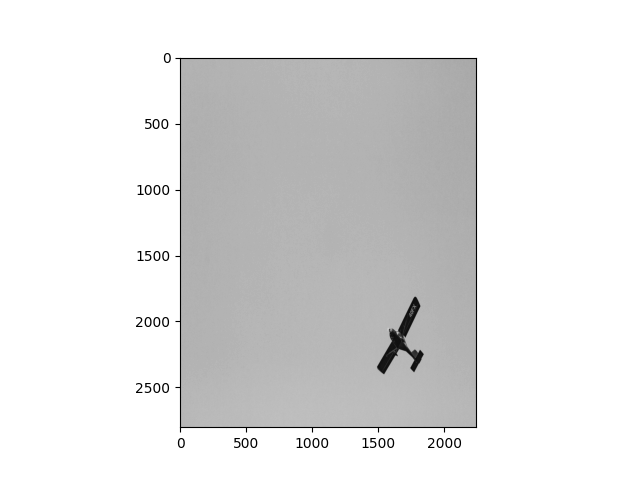

In [356]:
source = cv2.imread('img2.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
target = cv2.imread('img.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

# Resize source to match target dimensions
source_resized = cv2.resize(source, (target.shape[1], target.shape[0]))

vertices = mark_vertices(source_resized)
# vertices = [[1517, 2014], [1548, 2158], [1457, 2348], [1540, 2454], [1669, 2234], [1745, 2302], [1699, 2386], [1775, 2454], [1904, 2227], [1836, 2173], [1760, 2211], [1707, 2128], [1836, 1870], [1783, 1741], [1639, 2014]]



## 2-a Importing gradient

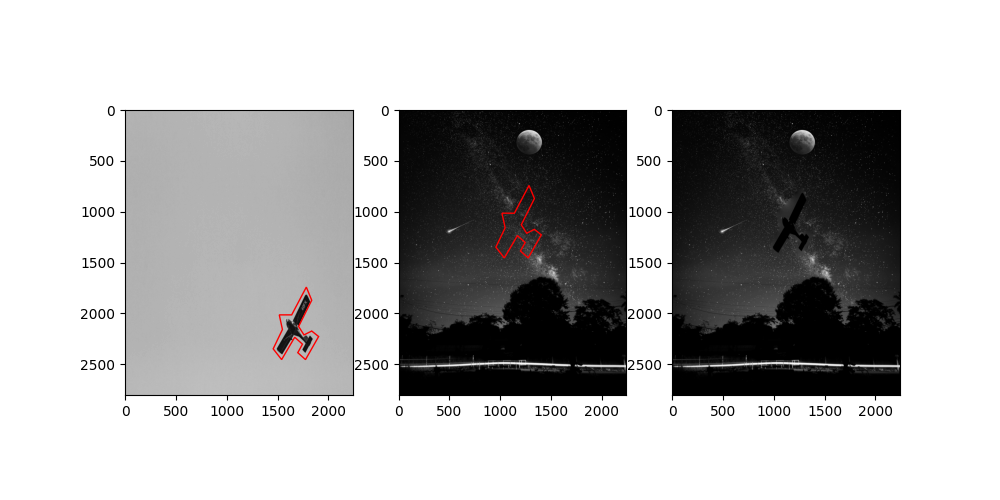

In [ ]:
offset = np.array([-500, -1000])

new_img_import = apply_gradient(source_resized, target, offset, vertices, mode='import')
plot_imgs_clone(source_resized, target, new_img_import, vertices, offset)

## 2-b Mixing gradient

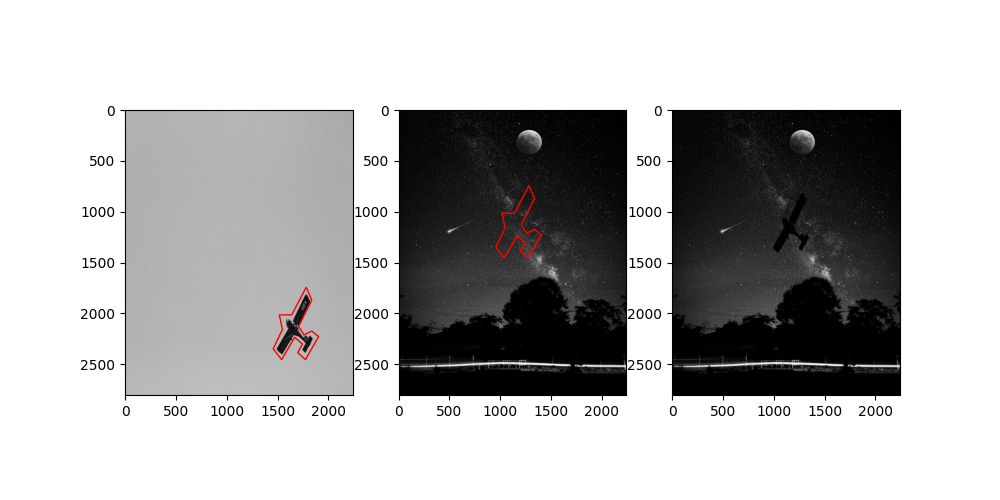

In [359]:
new_img_mixed = apply_gradient(source_resized, target, offset, vertices, mode='mixed')
plot_imgs_clone(source_resized, target, new_img_mixed, vertices, offset)

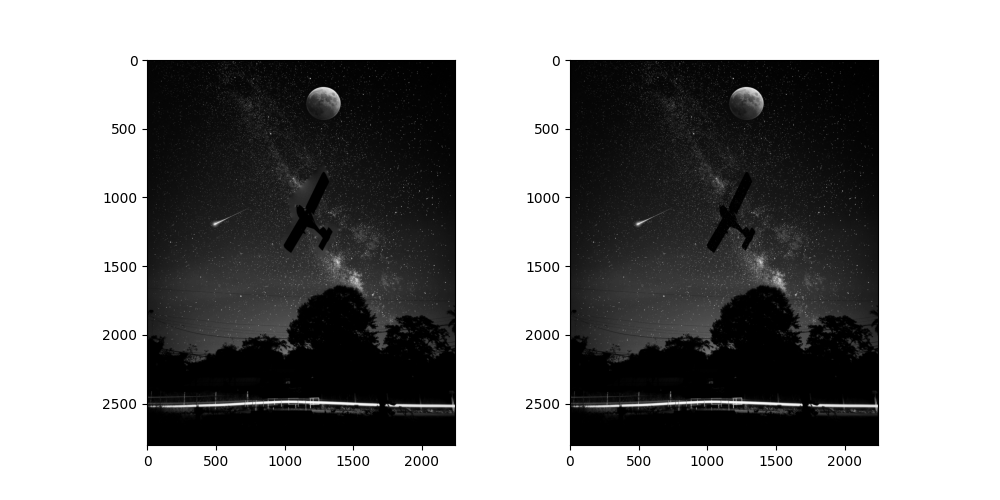

In [362]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(new_img_import, cmap='gray')
ax[1].imshow(new_img_mixed, cmap='gray')

The left image shows the airplane copied into the background, creating a less natural transition, while the right image, using mixing gradient, achieve a more seamless cloning.

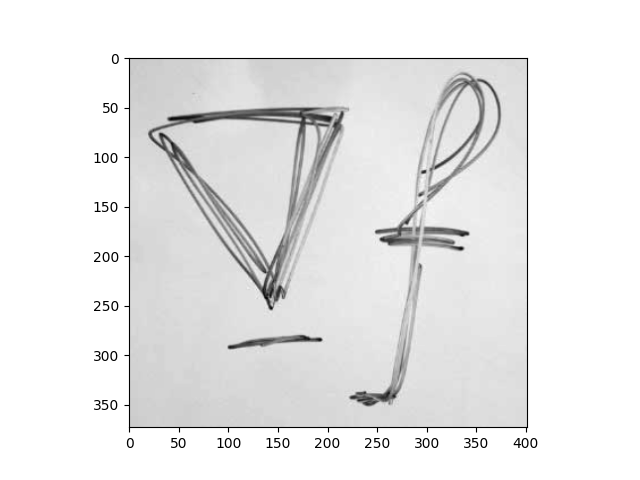

In [381]:
img3 = cv2.imread('img3.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
img4 = cv2.imread('img4.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

img4_resized = cv2.resize(img4, (img3.shape[1], img3.shape[0]))
vertices_img4 = mark_vertices(img4_resized)

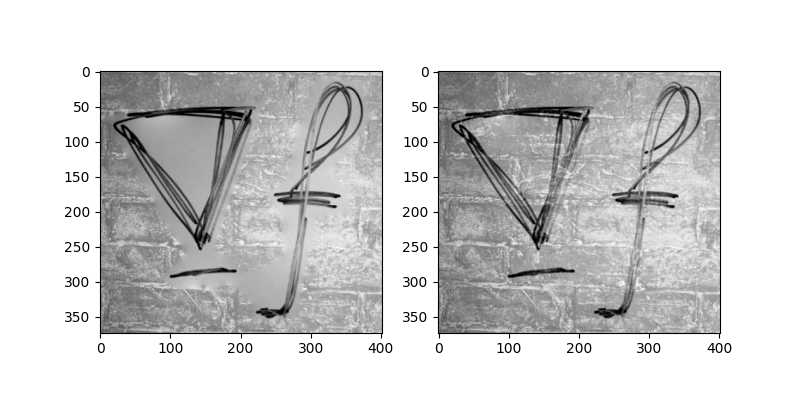

In [384]:
offset = np.array([0, 0])
img4_import = apply_gradient(img4_resized, img3, offset, vertices_img4, mode='import')
img4_mixed = apply_gradient(img4_resized, img3, offset, vertices_img4, mode='mixed')

fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(img4_import, cmap='gray')
ax[1].imshow(img4_mixed, cmap='gray')

Normal seamless cloning does not perform well when inserting objects with holes, leading to blurred portions in the target image. However, mixed gradients method is effective by better preserving the clarity of the target area.

# Task3: Colored Images

In [607]:
def apply_gradient_color(src, dst, offset, vertices, mode):
    channels = []
    for i in range(3):
        src_channel = src[:, :, i]
        dst_channel = dst[:, :, i]
        new_img_channel = apply_gradient(src_channel, dst_channel, offset, vertices, mode)
        channels.append(new_img_channel)
    
    return np.stack(channels, axis=-1)  # axis=-1 means combine the channels along the last dimension


In [608]:
color_img = cv2.imread('img.jpg', cv2.IMREAD_COLOR).astype(np.float32) / 255.0
color_img2 = cv2.imread('img2.jpg', cv2.IMREAD_COLOR).astype(np.float32) / 255.0
color_img2_resized = cv2.resize(color_img2, (color_img.shape[1], color_img.shape[0]))

color_img2_resized = color_img2_resized[..., ::-1]
color_img = color_img[..., ::-1] # ::-1 is to reverse the order of the channels (BGR to RGB)
vertices = [[1517, 2014], [1548, 2158], [1457, 2348], [1540, 2454], [1669, 2234], [1745, 2302], [1699, 2386], [1775, 2454], [1904, 2227], [1836, 2173], [1760, 2211], [1707, 2128], [1836, 1870], [1783, 1741], [1639, 2014]]


In [609]:
offset = np.array([-500, -1000])
color_img_import = apply_gradient_color(color_img2_resized, color_img, offset, vertices, mode='import')
color_img_mixed = apply_gradient_color(color_img2_resized, color_img, offset, vertices, mode='mixed')

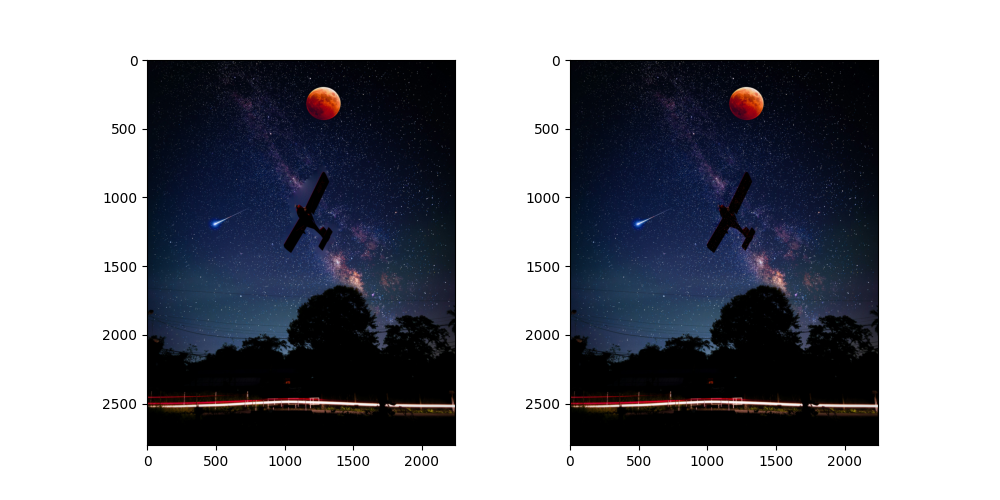

In [610]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(color_img_import, cmap='gray')
ax[1].imshow(color_img_mixed, cmap='gray')

In [443]:
img3 = cv2.imread('img3.jpg', cv2.IMREAD_COLOR).astype(np.float32) / 255.0
img4 = cv2.imread('img4.jpg', cv2.IMREAD_COLOR).astype(np.float32) / 255.0
img4_resized = cv2.resize(img4, (img3.shape[1], img3.shape[0]))
img4_resized = img4_resized[..., ::-1]
img3 = img3[..., ::-1]

offset = np.array([0, 0])
color_img4_import = apply_gradient_color(img4_resized, img3, offset, vertices_img4, mode='import')
color_img4_mixed = apply_gradient_color(img4_resized, img3, offset, vertices_img4, mode='mixed')


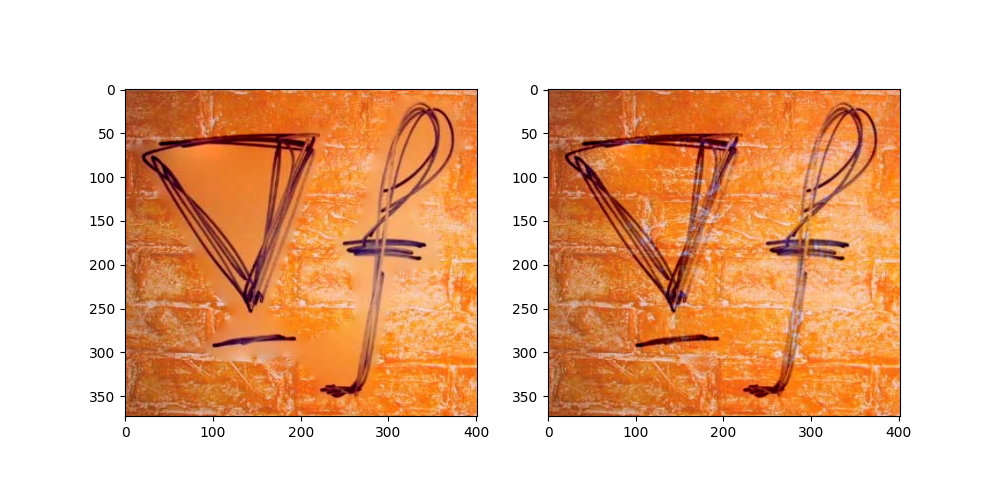

In [444]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(color_img4_import, cmap='gray')
ax[1].imshow(color_img4_mixed, cmap='gray')

# Task4: Local color changes

In [704]:
img5 = cv2.imread('img5.jpg', cv2.IMREAD_COLOR).astype(np.float32) / 255.0
img5 = img5[..., ::-1]  # Convert BGR to RGB 
vertices_img5 = mark_vertices(img5)
#vertices_img5 = [[279, 45], [228, 58], [182, 82], [154, 125], [139, 183], [141, 233], [156, 277], [186, 316], [224, 345], [261, 358], [308, 359], [385, 353], [429, 322], [463, 271], [475, 221], [477, 180], [464, 137], [442, 97], [413, 69], [373, 56], [355, 50], [364, 34], [343, 31], [335, 47], [307, 43]]

In [705]:
print(vertices_img5)

[[279, 45], [228, 58], [182, 82], [154, 125], [139, 183], [141, 233], [156, 277], [186, 316], [224, 345], [261, 358], [308, 359], [385, 353], [429, 322], [463, 271], [475, 221], [477, 180], [464, 137], [442, 97], [413, 69], [373, 56], [355, 50], [364, 34], [343, 31], [335, 47], [307, 43]]


In [722]:

from skimage.draw import polygon

def show_color_changes(img, vertices):
   fig, axes = plt.subplots(1, 3, figsize=(10, 5))
   
   # Left: Original image with selection
   axes[0].imshow(img)
   poly = plt.Polygon(vertices, fill=False, color='red')
   axes[0].add_patch(poly)
   axes[0].set_title('Original with Selection')
   
   # Center: Background decolorization
   rr, cc = polygon([v[1] for v in vertices], [v[0] for v in vertices], img.shape[:2])
   mask = np.zeros(img.shape[:2], dtype=bool)
   mask[rr, cc] = True
   
   decolor = img.copy()
   hsv = cv2.cvtColor(decolor, cv2.COLOR_RGB2HSV)
   gray_img = hsv[:, :, 2] # Extract the Value channel (luminance) from HSV
      
   for i in range(3):
      decolor[~mask, i] = gray_img[~mask]
   axes[1].imshow(decolor)
   axes[1].set_title('Background Decolorization')

   # Right: Recolored object
   # Add the hue shift, and then take modulo 180
   hue_shift = 100  # can change this value to get different color shifts
   hsv[mask, 0] = (hsv[mask, 0] + hue_shift) % 180
   hsv[mask, 0] = hsv[mask, 0].astype(np.uint8)
   output_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

   axes[2].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
   axes[2].set_title('Recolored Object')
   
   plt.tight_layout()
   plt.show()
   
   

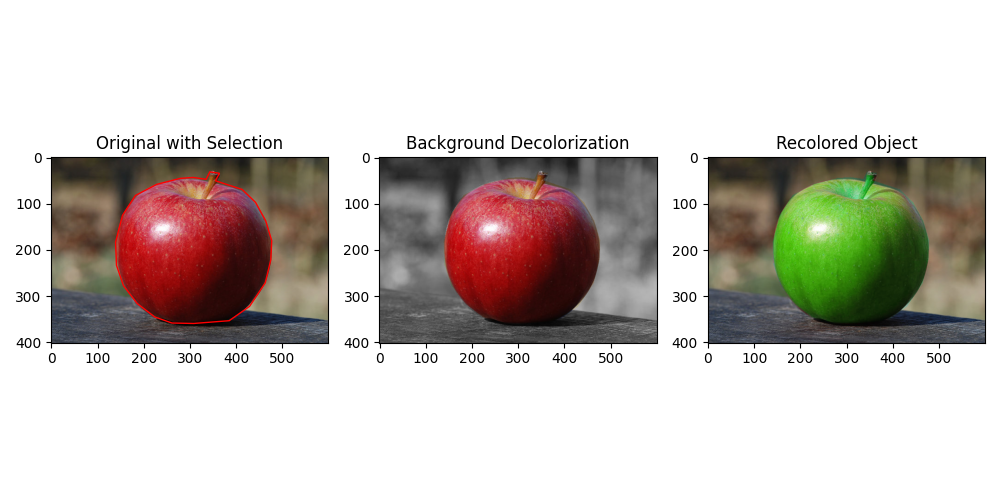

In [721]:
show_color_changes(img5, vertices_img5)


1. Original with selection: The original image is displayed with the selected region (Ω) loosely 
surrounding the object of interest.
2. Background decolorization: The destination image is set to be the luminance channel from the original image using the HSV color space,
while keeping the color of the selected region.
3. Recolored object: Instead of directly modifying the RGB channels, the hue component in the HSV color space is adjusted to alter the object's color. This aviods the distortions with RGB manipulations, resulting in a more natural color shift.

Using RGB channels multiplication for color changes does not ensure a perfect segmentation, often resulting in residual color contamination of the destination image outside the object.